# IMBD Sentimental Analysis Review

El siguiente proyecto tiene como objetivo la aplicación de técnicas de NLP para realizar un análisis de sentimientos sobre un dataset formado por reviews de diferentes películas de la base de datos IMBD. Todas ellas vienen correctamente tagueadas con su correspondiente sentimiento, positivo o negativo.

# Índice

**[0. Librerias](#heading--1)**

**[1. Carga de Datos](#heading--2)**

**[2. Análisis Exploratorio](#heading--3)**

**[3. PreProcesado](#heading--4)**

**[4. División de Datos](#heading--5)**

**[5. Tokenización de Datos](#heading--6)**

**[6. Modelos](#heading--7)**

  * [6.1. Red Neuronal Simple](#heading--7-1)
  
  * [6.2. CNN](#heading--7-2)

  * [6.2. RNN + CNN](#heading--7-3)

  * [6.4. LTSM](#heading--7-4)
  
**[7. Transformers](#heading--8)**

**[8. Comparación](#heading--9)**

**[9. Lineas de Investigación](#heading--10)**



<div id="heading--1"/>

## 0. Librerias

Importamos los paquetes que necesitaremos para poder trabajar:

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
import wordcloud
import matplotlib
import transformers
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras import layers
from datasets import load_dataset

<div id="heading--2"/>

## 1. Carga de datos

La siguiente parte solo será necesaria si se trabaja desde Google Colab, además las rutas se deberán cambiar.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ./drive/MyDrive/IMBD_Project

/content/drive/MyDrive/IMBD_Project


In [12]:
!ls "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Texto"

Codigo.ipynb  CodigoMain.ipynb	IMBD_data.csv


Una vez ya hemos configurado la entrada y carga de datos de Google Drive lo que haremos será cargar los datos con los que trabajaremos. Estos serán un csv formado por las reviews y su tag en cuanto al sentimiento.

In [7]:
reviews = pd.read_csv("./IMBD_data.csv")

In [8]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


A su vez cargaremos también los datos de las stop words, en inglés ya que las reviews están en inglés:

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alvarorodriguezgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopwords = set(stopwords.words('english'))

In [11]:
print(stopwords)

{'an', "it's", 'did', 'at', "you're", 'been', 'too', 'up', 'this', 'them', "mightn't", 'why', 'wouldn', 'can', 'yourselves', 'you', 'below', 'through', 'just', 'his', "didn't", 'and', 'o', 'it', "you'll", 'nor', 'itself', 're', 'they', 'each', 'out', 'aren', 'of', 'be', 'she', 'mightn', 'a', 'not', 'are', 'ain', 'where', 'needn', 'doesn', "you've", 'so', 'does', 'couldn', "she's", 'whom', 'myself', 'don', 'what', 'was', "wasn't", 'into', 'very', 'do', 'their', 'i', 'y', 'from', 'has', 'only', "hasn't", "isn't", 'my', 'isn', 'some', 'over', 'as', 'again', 'll', 'our', 'between', 'all', 'same', 'in', 'themselves', 'being', 'should', "couldn't", 'him', 'such', 'your', 'yours', 'm', 't', "should've", 'there', 'how', 'after', 'then', 'few', 'before', 'own', 'weren', 'above', 'most', 'he', 'doing', 'ours', 'her', 'haven', 'here', 'the', "aren't", 'shouldn', 'while', "wouldn't", 'now', 'under', "mustn't", 'that', 'have', 'its', 'down', 'both', "shouldn't", 'during', 'yourself', 'other', 'must

<div id="heading--3"/>

## 2. Análisis Exploratorio

Veamos si nuestros datos estan balanceados:

<AxesSubplot:xlabel='sentiment', ylabel='count'>

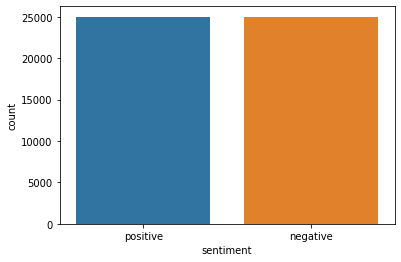

In [12]:
sns.countplot(x = "sentiment", data = reviews)

A continuación realizaremos un análisis de las palabras:

In [20]:
def get_word_tokens(sentences):
    words = []
    for sent in sentences:
        words.extend(word_tokenize(sent))
    print(words)
    return(words)

Pasamos las reviews a una lista para poder trabajar con ello:

In [ ]:
reviews_lista = list(reviews['review'])

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
review_words = get_word_tokens(reviews_lista)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
matplotlib.use('TkAgg')

Creamos una función que nos saque una distribución de frecuencias de las diferentes palabras.

In [25]:
def plot_freq_dist(words, num_words = 20):
    fdist = FreqDist(words)
    fdist.plot(num_words,cumulative=False)

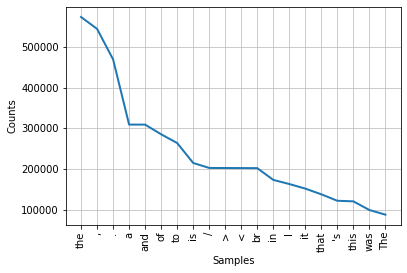

In [ ]:
plot_freq_dist(review_words, num_words=20)

Como es facilmente observable la gran mayoria de palabras que más se repiten o son algunas incluidas en las stop words o son símbolos debidos a la técnica usada para obtener los datos. Para verlo correctamente tendremos que hacer un preprocesado.

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def get_pos_tags(words):
    tags=[]
    for word in words:
        tags.append(nltk.pos_tag([word]))
    print(tags)
    return tags

In [ ]:
sample_tags = get_pos_tags(review_words)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-b9e2f97bd742>", line 1, in <module>
    sample_tags = get_pos_tags(review_words)
  File "<ipython-input-31-458de68e768a>", line 4, in get_pos_tags
    tags.append(nltk.pos_tag([word]))
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/__init__.py", line 133, in pos_tag
    tagger = _get_tagger(lang)
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/__init__.py", line 97, in _get_tagger
    tagger = PerceptronTagger()
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/perceptron.py", line 141, in __init__
    self.load(AP_MODEL_LOC)
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/perceptron.py", line 223, in load
    self.model.weights, self.tagdict, self.classes = load(loc)
  File "/usr/local/lib/python3.7/dist-packages/nltk/data.py", line 803, 

KeyboardInterrupt: ignored

In [ ]:
tag_fd = nltk.FreqDist(l[0][1] for l in sample_tags)
tag_fd.most_common()

Aquí explicaremos qué es cada tag de los más repetidos:


1.   NN: Noun
2.   NNS: Noun plural
3.   JJ: This NLTK POS Tag is an adjective
4.   RB: Adverb
5.   VGB: Verb gerund
6.   VBN: Verb past participle
7.   VB Verb
8.   IN: Preposition/subordinating conjunction
9.   CD: Cardinal digit
10.  Verb past tense 


In [ ]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words)).lower())

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off")

<div id="heading--4"/>

## 3. Preprocesado

Como se puede ver en el caso que se encuentra abajo, podemos encontrarnos con tags de código html:

In [13]:
reviews.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Para ello crearemos una función que te permita eliminar todos los tags del código:

In [14]:
def tags_out(review,stopwords):
    review = review.lower()
    review = re.sub('<br />','',review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    for palabra in stopwords:
        review = re.sub(' ' + palabra + ' ',' ', review)
    review = re.sub(r'\s+',' ', review)
    return review

In [15]:
tags_out(reviews.iloc[1,0],stopwords)

'a wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

Una vez visto que nuestra función trabaja correctamente vamos a aplicarselo a todas las reviews:

In [16]:
reviews_list_pp = list(reviews['review'])
review_post = [tags_out(review,stopwords) for review in reviews_list_pp]

Por último pasaremos de string a integer la columna sentimientos:

In [17]:
sentimiento = reviews['sentiment']
sentimiento = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentimiento)))

Ahora volveremos a hacer un análisis exploratorio habiendo hecho un preprocesado de los datos:

In [18]:
!--NotebookApp.iopub_data_rate_limit = 1000000000

zsh: no such option: NotebookApp.iopub_data_rate_limit = 1000000000


Como hemos comentado antes, al no haber preprocesado los datos nos salían como palabras más usadas o stop words o símbolos. Una vez que hemos preprocesado los datos vamos a volver a lanzar la función y ver que nos devuelve.

In [22]:
review_words_pp = get_word_tokens(review_post)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
matplotlib.use('TkAgg')

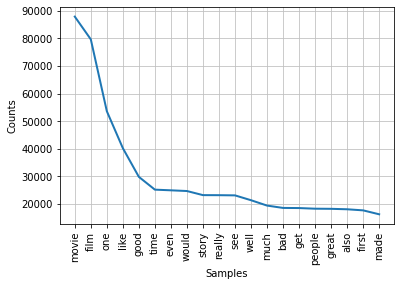

In [26]:
plot_freq_dist(review_words_pp, num_words=20)

In [27]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words_pp)).lower())

(-0.5, 999.5, 999.5, -0.5)

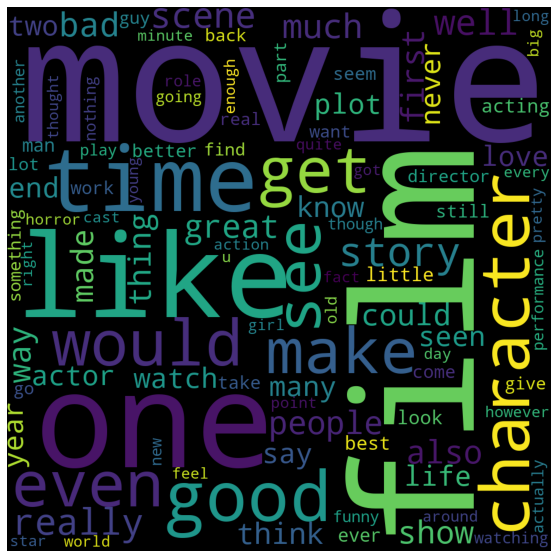

In [28]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off")

<div id="heading--5"/>

## 4. División de datos

A continuación vamos a dividir los datos entre train y test, usando una semilla para evitar la aletoriedad.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(review_post, sentimiento,test_size=0.20, random_state=2022)

<div id="heading--6"/>

## 5. Proceso de Tokenización

Antes de tirar cualquier modelo lo que vamos a hacer es realizar el proceso de tokenización de los datos.

In [30]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 150 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

A continuación lo que haremos será crear un diccionario de embedding el cual nos resultará muy útil para los pesos de las diferentes redes:

In [32]:
def embeddings(path):
    embeddings_dictionary = dict()
    embeddings_file=open(path)
    for line in embeddings_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:],dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    embeddings_file.close()
    embedding_matrix = np.zeros((vocab_size, 100))
    
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

<div id="heading--7"/>

## 6. Modelos

Una cosa que será bastante importante es la evaluación del modelo. Para ello definiremos un par de funciones que permitan sacar los resultados.

In [33]:
def evaluateModel(model):
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Accuracy:", score[1])

In [34]:
def AccLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

Y a su vez también sacaremos la matriz de embedding usando el archivo de word2vec.

In [35]:
embedding_matrix = embeddings('./word2vec.txt')

A continuación ya comenzaremos a lanzar modelos, donde trabajaremos con redes neuronales simples, CNN, RNN + CNN y LTSM.

<div id="heading--5-1"/>

### 6.1. Red Neuronal Simple

In [36]:
random_state = 2022

In [40]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False),
          layers.Flatten(),
          layers.Dense(10,activation = "sigmoid"),
          layers.Dropout(0.1),
          layers.Dense(5,activation = "sigmoid"),
          layers.Dense(1,activation="sigmoid")
      ]
  )

In [41]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [42]:
history = model.fit(x=X_train,y=y_train,batch_size=256,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 2s 9ms/step - loss: 0.7075 - acc: 0.4997 - val_loss: 0.6842 - val_acc: 0.4958
Epoch 2/5
125/125 [==============================] - 1s 9ms/step - loss: 0.6259 - acc: 0.6217 - val_loss: 0.5790 - val_acc: 0.8264
Epoch 3/5
125/125 [==============================] - 1s 9ms/step - loss: 0.5166 - acc: 0.8537 - val_loss: 0.4971 - val_acc: 0.8364
Epoch 4/5
125/125 [==============================] - 1s 9ms/step - loss: 0.4196 - acc: 0.8898 - val_loss: 0.4464 - val_acc: 0.8336
Epoch 5/5
125/125 [==============================] - 1s 9ms/step - loss: 0.3432 - acc: 0.9098 - val_loss: 0.4195 - val_acc: 0.8378


In [43]:
evaluateModel(model)

313/313 [==============================] - 1s 2ms/step - loss: 0.4198 - acc: 0.8371
Test Accuracy: 0.8371000289916992


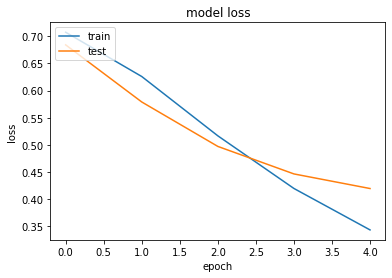

In [44]:
AccLoss(history)

## Conclusión del modelo


Tras observar la pérdida de este modelo vemos que parte de 0.7, tanto el train como el test, descendiendo hasta alcanzar unos valores de 0.35 y 0.45 respectivamente. Además, observamos que, a partir del 2º epoch, las pérdidas empiezan a alejarse asegurando overfitting

<div id="heading--5-2"/>

### 6.2. CNN

In [45]:
random_state = 2022

In [54]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen),
          layers.Conv1D(filters=64,kernel_size=4,activation="relu"),
          layers.MaxPooling1D(),
          layers.Conv1D(filters=32,kernel_size=3,activation="relu"),
          layers.MaxPooling1D(),
          layers.Flatten(),
          layers.Dense(5,activation="sigmoid"),
          layers.Dense(1,activation="sigmoid"),
      ]
  )

In [55]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [56]:
history = model.fit(x=X_train,y=y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 36s 140ms/step - loss: 0.5270 - acc: 0.7662 - val_loss: 0.4185 - val_acc: 0.8696
Epoch 2/5
250/250 [==============================] - 32s 129ms/step - loss: 0.3789 - acc: 0.8775 - val_loss: 0.4021 - val_acc: 0.8403
Epoch 3/5
250/250 [==============================] - 31s 123ms/step - loss: 0.3181 - acc: 0.8962 - val_loss: 0.3335 - val_acc: 0.8820
Epoch 4/5
250/250 [==============================] - 32s 129ms/step - loss: 0.2671 - acc: 0.9168 - val_loss: 0.3274 - val_acc: 0.8820
Epoch 5/5
250/250 [==============================] - 37s 147ms/step - loss: 0.2215 - acc: 0.9355 - val_loss: 0.3121 - val_acc: 0.8811


In [57]:
evaluateModel(model)

313/313 [==============================] - 2s 5ms/step - loss: 0.2995 - acc: 0.8877
Test Accuracy: 0.8877000212669373


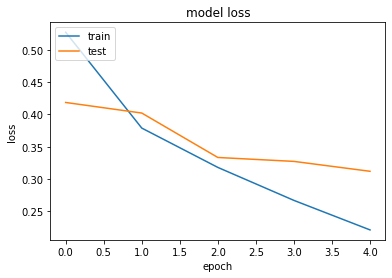

In [58]:
AccLoss(history)

# Conclusión del modelo

Tras observar la pérdida de este modelo vemos que parte de 0.6 el train y 0.42 el test, descendiendo hasta alcanzar unos valores de 0.20 y 0.35 respectivamente. Además, observamos que, a partir del 2º epoch, las pérdidas empiezan a alejarse asegurando overfitting

<div id="heading--5-3"/>

### 6.3. RNN + CNN

In [ ]:
random_state = 2022

In [ ]:
model = keras.Sequential([
    layers.Embedding(vocab_size,100, weights=[embedding_matrix],input_length=maxlen),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=3),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [ ]:
history= model.fit(x=X_train,y=y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 103s 404ms/step - loss: 0.3871 - acc: 0.8202 - val_loss: 0.3124 - val_acc: 0.8717
Epoch 2/5
250/250 [==============================] - 124s 496ms/step - loss: 0.2775 - acc: 0.8861 - val_loss: 0.2851 - val_acc: 0.8811
Epoch 3/5
250/250 [==============================] - 104s 418ms/step - loss: 0.2312 - acc: 0.9082 - val_loss: 0.2769 - val_acc: 0.8851
Epoch 4/5
250/250 [==============================] - 100s 401ms/step - loss: 0.1822 - acc: 0.9294 - val_loss: 0.2986 - val_acc: 0.8848
Epoch 5/5
250/250 [==============================] - 100s 399ms/step - loss: 0.1363 - acc: 0.9501 - val_loss: 0.3293 - val_acc: 0.8824


In [ ]:
evaluateModel(model)

313/313 [==============================] - 8s 24ms/step - loss: 0.3206 - acc: 0.8856
Test Accuracy: 0.8855999708175659


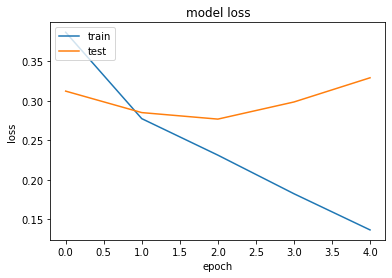

In [ ]:
AccLoss(history)

# Conclusión del modelo

Tras observar la pérdida de este modelo vemos que parte de 0.4 el train y de 0.32 el test. Además observamos que el único punto en el que no hay overfitting sería en el epoch 1 ya que, tras esto las pérdidas tienden a alejarse, aumentando hasta 0.35 el test y descendiendo hasta 0.15 el train

<div id="heading--5-4"/>

### 6.4. LTSM

In [59]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen),
          layers.LSTM(128),
          layers.Dense(1,activation="sigmoid"),
      ]
  )

In [60]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [61]:
history= model.fit(x=X_train,y=y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 93s 366ms/step - loss: 0.6414 - acc: 0.6136 - val_loss: 0.6380 - val_acc: 0.6062
Epoch 2/5
250/250 [==============================] - 91s 364ms/step - loss: 0.6011 - acc: 0.6800 - val_loss: 0.5855 - val_acc: 0.6830
Epoch 3/5
250/250 [==============================] - 93s 374ms/step - loss: 0.6295 - acc: 0.6156 - val_loss: 0.7172 - val_acc: 0.5281
Epoch 4/5
250/250 [==============================] - 93s 371ms/step - loss: 0.4474 - acc: 0.8120 - val_loss: 0.4095 - val_acc: 0.8404
Epoch 5/5
250/250 [==============================] - 93s 371ms/step - loss: 0.3315 - acc: 0.8664 - val_loss: 0.3144 - val_acc: 0.8734


In [62]:
evaluateModel(model)

313/313 [==============================] - 11s 36ms/step - loss: 0.3012 - acc: 0.8780
Test Accuracy: 0.878000020980835


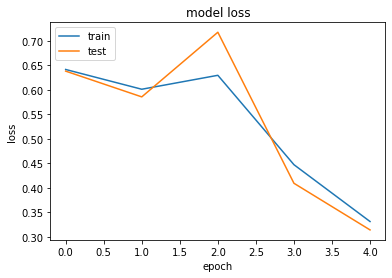

In [63]:
AccLoss(history)

# Conclusión del modelo

Tras observar la pérdida de este modelo vemos que parte de 0.65, tanto el train como el test, descendiendo hasta alcanzar unos valores de 0.60 , ascendiendo luego a 0.65 el train y 0,7 el test (presentando overfitting). Sin embargo, tras el epoch 2 vuelven a juntarse estas rectas pudiendo afirmar que se corrige el overfitting, además de descender hasta unos valores de 0.35

<div id="heading--8"/>

## 7. Transformers

Lo primero de todo va a ser dividir los datos entre train, test y validación.

In [66]:
train, test = train_test_split(reviews, test_size=0.20, random_state=2022)
train, validation = train_test_split(train, test_size=0.20, random_state=2022)

In [67]:
train

,review,sentiment
6254,"Years ago, when I was a poor teenager, my best...",negative
39291,"When I went and saw this movie, I had great ex...",negative
23759,Buddy Holly was a pioneer and victim of the ea...,positive
36109,This is NOT your run-of-the mill police story ...,positive
10584,This is a neat little crime drama which packs ...,positive
...,...,...
39282,Although there is very little plot and whateve...,negative
7518,This is the worst movie I have ever seen. A mo...,negative
15406,This movie was disappointing for at least one ...,negative
22600,I've come to realise through watching this sor...,negative


In [106]:
train[["review", "sentiment"]].to_csv("./train.csv", header=["review", "sentiment"], index=False)
test[["review", "sentiment"]].to_csv("./test.csv", header=["review", "sentiment"], index=False)
validation[["review", "sentiment"]].to_csv("./validation.csv", header=["review", "sentiment"], index=False)

In [108]:
dataset_dict = load_dataset("csv", data_files = {"train": "./train.csv",
                                                 "validation": "./validation.csv",
                                                 "test": "./test.csv"})


Using custom data configuration default-2ade44e1ce9734a9


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2ade44e1ce9734a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [109]:
from transformers import AutoTokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

In [110]:
def tokenize_function(dataset_dict):
    return tokenizer(dataset_dict["review"], truncation = True, padding = True)

In [111]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 32000
    })
    validation: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 10000
    })
})

In [122]:
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-2ade44e1ce9734a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b400e078c438e454.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-2ade44e1ce9734a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d21d5b1c2564d303.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-2ade44e1ce9734a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4f267d9aedfcfbbf.arrow


In [84]:
tokenized_dataset

Dataset({
    features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 50000
})

In [114]:
tokenized_dataset["train"][0]["input_ids"]

[101,
 2086,
 3283,
 1010,
 2043,
 1045,
 2001,
 1037,
 3532,
 10563,
 1010,
 2026,
 2190,
 2767,
 1998,
 2026,
 2567,
 2119,
 2018,
 1037,
 3343,
 2008,
 1996,
 2711,
 8130,
 1996,
 3185,
 2323,
 3477,
 1012,
 1998,
 1010,
 2096,
 1045,
 2052,
 2196,
 3477,
 2000,
 2156,
 2070,
 1997,
 1996,
 10231,
 2027,
 2165,
 2033,
 2000,
 1010,
 1045,
 2481,
 1005,
 1056,
 9507,
 1037,
 2489,
 4440,
 2000,
 1996,
 5691,
 999,
 2008,
 1005,
 1055,
 2129,
 1045,
 2234,
 2000,
 2156,
 10231,
 2066,
 1996,
 2117,
 16608,
 3185,
 1998,
 2196,
 2360,
 2196,
 2153,
 999,
 2085,
 1010,
 2750,
 2023,
 2108,
 1037,
 23277,
 29574,
 3185,
 1010,
 2009,
 2003,
 1999,
 3182,
 14036,
 2000,
 3422,
 1011,
 1011,
 1999,
 1037,
 4167,
 2757,
 4066,
 1997,
 2126,
 1012,
 1998,
 1010,
 10892,
 1996,
 28465,
 1998,
 4950,
 1011,
 2147,
 2024,
 2204,
 1010,
 2061,
 2023,
 3449,
 13331,
 4570,
 2026,
 5790,
 2035,
 1996,
 2126,
 2000,
 1037,
 1016,
 999,
 2061,
 2339,
 2003,
 1996,
 3185,
 2061,
 2919,
 1029,
 2092,


In [123]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [124]:
tokenized_datasets = tokenized_dataset.remove_columns(["review"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['sentiment', 'input_ids', 'token_type_ids', 'attention_mask']

In [125]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle = True, batch_size = 8, collate_fn = data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size = 8, collate_fn = data_collator
)

In [126]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification


training_args = TrainingArguments("sentiment")
checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": 

In [128]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cpu')

In [129]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12000
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentiment, review. If sentiment, review are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


In [1]:
preditions = trainer.predict(tokenized_datasets["test"])

NameError: ignored

In [2]:
import numpy as np

y_pred = np.argmax(predictions.predictions, axis = 1)

NameError: ignored

In [3]:
from sklearn.metrics import accuracy_score

print("Accuracy: " + str(accuracy_score(list(test["sentiment"]), y_pred)))



NameError: ignored

<div id="heading--9"/>

## 8. Comparaciones

Tras estudiar con detenimiento los modelos entrenados, descartando el modelo usando transformers, ya que hemos sido incapaces de optimizarlo, hemos llegado a la conclusión de que el mejor modelo sería el LTSM ya que, a pesar de no conseguir los valores más bajos de pérdida, es el único capaz de corregir el overfitting y conseguir unos resultados que, con un entrenamiento más largo en número de epochs, probablemente se conseguiría llegar a un valor de pérdida óptimo tanto en train como en test

<div id="heading--10"/>

## 9. Lineas de Investigación

Dentro de las posibles lineas de investigación podemos encontrar las siguientes ideas:

- Combinación de varios modelos sencillos que funcionen "bien" de forma individual.

- Conseguir que los transformers vayan.

- Conocer los casos donde falla y tratar de entender porque o si se repite algún patrón dentro del fallo.

- Búsqueda de métodos innovadores dentro del mundo del NLP.